In [ ]:
# default_exp dataset
# all_slow

# Datasets

> Fastai DataBlock API to Severstal datasets.

In [ ]:
# hide
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
! [ -e /content ] && pip install -Uqq albumentations  # upgrade albumentations

In [ ]:
# hide
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/severstal")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# export
from fastai.vision.all import *
import fastai

import albumentations as alb
from albumentations.augmentations.geometric.resize import Resize

from steel_segmentation.utils import get_train_df, get_train_pivot
from steel_segmentation.transforms import (
    ReadImagePathFromIndex, ReadRLEs, 
    AlbumentationsTransform, ChannelMask,
    SteelMaskBlock
)

In [6]:
print(fastai.__version__)
print(alb.__version__)

2.5.2
1.0.3


In [ ]:
#export
HEIGHT, WIDTH = (224, 1568)

def get_train_aug(): 
    tfm_list = [
      alb.RandomCrop(HEIGHT, WIDTH, p=1.0),
      #alb.Resize(128, 800),
      alb.OneOf(
          [
           alb.VerticalFlip(p=0.5),
           alb.HorizontalFlip(p=0.5),
          ], p=0.6),
      alb.OneOf(
          [
           alb.RandomBrightnessContrast(
               brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
           alb.RandomGridShuffle(grid=(1, 2), p=0.2),
          ], p=0.6),
    ]
    return alb.Compose(tfm_list)

def get_valid_aug(): 
    tfms = [alb.RandomCrop(HEIGHT, WIDTH)]
    return alb.Compose(tfms)

In [7]:
# export
def SteelDataBlock(path, splitter, flatten_mask=False, *args, **kwargs) -> DataBlock:
    """Get the DataBlock for Severstal Dataset.

    Parameters
    ----------
    path : pathlib.Path
        [description]
    splitter : [type]
        [description]
    flatten_mask : bool, optional
        [description], by default False

    Returns
    -------
    DataBlock
        [description]
    """
    get_x = ReadImagePathFromIndex(pref=(path/"train_images"))
    get_y = ReadRLEs()

    train_aug = get_train_aug()
    valid_aug = get_valid_aug()

    item_tfms = [ToTensor(), AlbumentationsTransform(train_aug, valid_aug)]
    batch_tfms=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    if not flatten_mask: batch_tfms += [ChannelMask()]

    block = DataBlock(
        blocks = (ImageBlock, SteelMaskBlock),
        get_x = get_x,
        get_y = get_y,
        splitter = splitter,
        item_tfms = item_tfms,
        batch_tfms = batch_tfms,
        *args, **kwargs
    )
    return block

In [8]:
path = Path("../../data/")

df = get_train_df(path)
df_pivot = get_train_pivot(df)

splitter = TrainTestSplitter(0.15)

block = SteelDataBlock(path, splitter)
block.summary(df_pivot)

Setting-up type transforms pipelines
ImageId              
0002cc93b.jpg  NaN   
00031f466.jpg   -1   
000418bfc.jpg   -1   
000789191.jpg   -1   
0007a71bf.jpg  NaN   
...            ...   
fff0295e1.jpg   -1   
fff02e9c5.jpg  NaN   
fffe98443.jpg  NaN   
ffff4eaa8.jpg  NaN   
ffffd67df.jpg  NaN   

ClassId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1  \
ImageId                                                                         

Setting up after_item: Pipeline: AddMaskCodes -> AlbumentationsTransform -- {} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: ChannelMask -> IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> AlbumentationsTransform -- {} -> ToTensor
    starting from
      (PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)
    applying AddMaskCodes gives
      (PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)
    applying AlbumentationsTransform -- {} gives
      (PILImage mode=RGB size=1568x224, PILMask mode=F size=1568x224)
    applying ToTensor gives
      (TensorImage of size 3x224x1568, TensorMask of size 224x1568)

Adding the next 3 samples


/home/marco/miniconda3/envs/severstal/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: ChannelMask -> IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
    starting from
      (TensorImage of size 4x3x224x1568, TensorMask of size 4x224x1568)
    applying ChannelMask gives
      (TensorImage of size 4x3x224x1568, TensorMask of size 4x4x224x1568)
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 4x3x224x1568, TensorMask of size 4x4x224x1568)
    applying Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)} gives
      (TensorImage of size 4x3x224x1568, TensorMask of size 4x4x224x1568)


## Test the API

In [9]:
from steel_segmentation.transforms import MakeMask

In [11]:
tfm_path = ReadImagePathFromIndex(pref=(path/"train_images"))
tfm_rles = ReadRLEs(cols=[1,2,3,4])

tfm_mask = MakeMask()
tfm_splitter = TrainTestSplitter(0.15)
tfm_addCodes = AddMaskCodes([1,2,3,4])

train_aug = get_train_aug()
valid_aug = get_valid_aug()
tfm_alb = AlbumentationsTransform(train_aug, valid_aug)

tfm_toTensor = ToTensor()
tfm_toFloat = IntToFloatTensor()
tfm_mask4chs = ChannelMask()

In [12]:
elem = 1235
df_elem = df_pivot.iloc[elem]

Get x:

In [13]:
elem_path = tfm_path(df_elem)
elem_path

'../../data/train_images/193eeae52.jpg'

Get y:

In [14]:
elem_rles = tfm_rles(df_elem)
elem_rles

['',
 '',
 '150273 55 150529 110 150785 111 151041 111 151297 112 151553 112 151809 113 152065 113 152321 114 152577 115 152815 133 153036 169 153258 203 153479 1401 154882 254 155138 254 155394 254 155650 254 155906 254 156162 254 156418 254 156674 241 156930 216 157186 190 157442 165 157698 140 157954 114 158210 89 158466 64 158722 38 158978 13 284417 30 284673 88 284929 147 285185 205 285441 235 285697 235 285953 235 286209 235 286465 235 286721 235 286977 235 287233 235 287489 234 287745 234 288001 234 288257 234 288513 234 288769 234 289025 234 289281 210 289537 164 289793 117 290049 70 290305 24 300289 29 300545 85 300801 141 301057 197 301313 225 301569 224 301825 224 302081 223 302338 221 302594 221 302850 220 303106 219 303362 219 303618 218 303874 217 304130 217 304386 216 304642 215 304898 214 305154 214 305410 213 305666 212 305922 212 306178 211 306435 209 306691 209 306947 208 307203 187 307459 145 307715 104 307971 63 308227 21 327425 32 327681 96 327937 160 328193 224 3

In [15]:
elem_mask = tfm_mask(elem_rles)
print("Shape: ", elem_mask.shape)
print("Mask pixels: ", np.unique(elem_mask))

Shape:  (256, 1600)
Mask pixels:  [0. 3.]


In [16]:
elem_decoded_mask = tfm_mask.decodes(elem_mask)
elem_decoded_mask

['',
 '',
 '150273 55 150529 110 150785 111 151041 111 151297 112 151553 112 151809 113 152065 113 152321 114 152577 115 152815 133 153036 169 153258 203 153479 1401 154882 254 155138 254 155394 254 155650 254 155906 254 156162 254 156418 254 156674 241 156930 216 157186 190 157442 165 157698 140 157954 114 158210 89 158466 64 158722 38 158978 13 284417 30 284673 88 284929 147 285185 205 285441 235 285697 235 285953 235 286209 235 286465 235 286721 235 286977 235 287233 235 287489 234 287745 234 288001 234 288257 234 288513 234 288769 234 289025 234 289281 210 289537 164 289793 117 290049 70 290305 24 300289 29 300545 85 300801 141 301057 197 301313 225 301569 224 301825 224 302081 223 302338 221 302594 221 302850 220 303106 219 303362 219 303618 218 303874 217 304130 217 304386 216 304642 215 304898 214 305154 214 305410 213 305666 212 305922 212 306178 211 306435 209 306691 209 306947 208 307203 187 307459 145 307715 104 307971 63 308227 21 327425 32 327681 96 327937 160 328193 224 3

In [17]:
test_eq(elem_rles, elem_decoded_mask)

Splits into train and validation ds:

In [18]:
splitter = L(tfm_splitter(df_pivot))

Datasets for train and valid example:

In [19]:
x_tfms = Pipeline([tfm_path, PILImage.create])
y_tfms = Pipeline([tfm_rles, tfm_mask, PILMask.create])
dsets = Datasets(df_pivot, [x_tfms, y_tfms], splits=splitter)

In [20]:
xy = dsets.train[0]
xy

(PILImage mode=RGB size=1600x256, PILMask mode=F size=1600x256)

In [21]:
t_xy = tfm_toTensor(xy)
print(f"Types: {t_xy[0].dtype}, {t_xy[1].dtype}")
t_xy[0].shape, t_xy[1].shape

Types: torch.uint8, torch.float32


(torch.Size([3, 256, 1600]), torch.Size([256, 1600]))

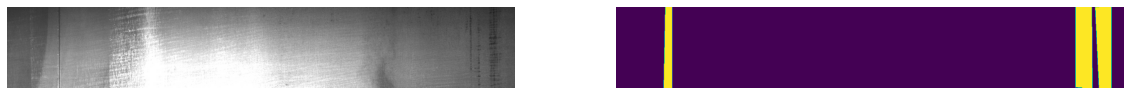

In [22]:
show_images(t_xy, figsize=(20,5))

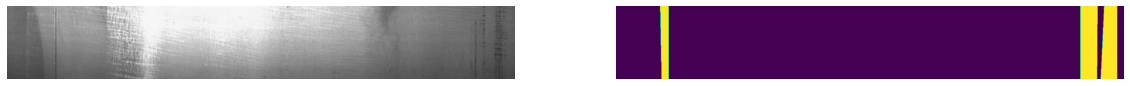

In [23]:
#%debug
augs = tfm_alb(xy, split_idx=0) #pipeline problem
show_images(augs, figsize=(20,5))

In [24]:
t_xy = tfm_addCodes(t_xy)
print(f"Types: {t_xy[0].dtype}, {t_xy[1].dtype}", )
t_xy[0].shape, t_xy[1].shape

Types: torch.uint8, torch.float32


(torch.Size([3, 256, 1600]), torch.Size([256, 1600]))

In [25]:
tch_xy = tfm_mask4chs(t_xy)
print(f"Types: {tch_xy[0].dtype}, {tch_xy[1].dtype}", )
tch_xy[0].shape, tch_xy[1].shape

Types: torch.uint8, torch.float32


(torch.Size([3, 256, 1600]), torch.Size([4, 256, 1600]))

In [26]:
tf_xy = tfm_toFloat(tch_xy)
print(f"Types: {tf_xy[0].dtype}, {tf_xy[1].dtype}", )
tf_xy[0].shape, tf_xy[1].shape

Types: torch.float32, torch.int64


(torch.Size([3, 256, 1600]), torch.Size([4, 256, 1600]))

In [27]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 11_eda.ipynb.
Converted 12_transforms.ipynb.
Converted 13_dataset.ipynb.
Converted index.ipynb.
